**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from collections import defaultdict

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [3]:
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

In [4]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

### CARICO il training ed il test set
....e provvedo ad effettuare modifiche: <ul>
<li>  spezzo la data in tempo e data
<li> rimozione umidity ratio
    <li> rimuovo outliers in Light

In [5]:
df=pd.read_csv(r'../data/training.csv')


In [6]:
df['date'] =  pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df['Time']= df['date'].apply(lambda x:x.time())
df['Date']= df['date'].apply(lambda x:x.date())
df['Time'] =  pd.to_timedelta(str(x) for x in df['Time'])
df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.drop('date', axis=1, inplace=True)

#df.drop('HumidityRatio',inplace=True,axis=1)
df=df[df['Light']<10000] 

In [7]:
test=pd.read_csv(r'../data/test.csv')

In [8]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB

In [9]:
test['date'] =  pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M:%S')
test['Time']= test['date'].apply(lambda x:x.time())
test['Date']= test['date'].apply(lambda x:x.date())
test['Time'] =  pd.to_timedelta(str(x) for x in test['Time'])
test['Date'] =  pd.to_datetime(test['Date'], format='%Y-%m-%d')
test.drop('date', axis=1, inplace=True)

#test.drop('HumidityRatio',inplace=True,axis=1)


# GAUSSIANO SENZA TEMPO

Dato che il tempo non è ben calcolabile dalla gaussiana decido di non utilizzarlo 
Infatti non è considerabile come un attributo continuo, ma è meglio considerarlo come categorico 

la fuzione gaussiana facendo la sifferenza tra due orari della giornata non andrebbe a considere la ciclicità del tempo.

In [10]:
attributes = ['Temperature','CO2','Light','Humidity'] 



    
X_train =df[attributes].values
y_train=df['Occupancy'].values
X_test=test[attributes].values
y_test=test['Occupancy'].values

attributes

['Temperature', 'CO2', 'Light', 'Humidity']

In [11]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred0=y_pred
y_score=clf.predict_proba(X_test)


print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9649805447470817
F1-score [0.97672915 0.92927308]
              precision    recall  f1-score   support

           0       1.00      0.95      0.98      4747
           1       0.87      1.00      0.93      1421

    accuracy                           0.96      6168
   macro avg       0.93      0.98      0.95      6168
weighted avg       0.97      0.96      0.97      6168



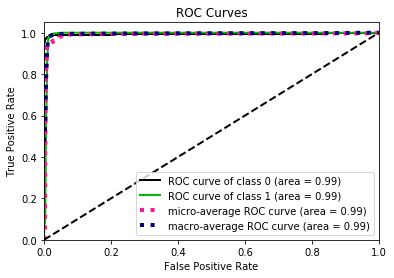

In [12]:
plot_roc(y_test, y_score)
plt.show()

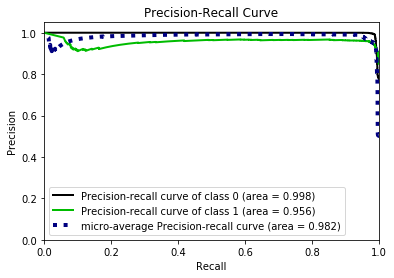

In [13]:
plot_precision_recall(y_test, y_score)
plt.show()

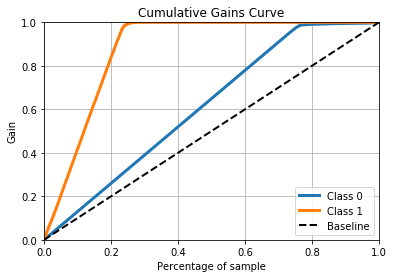

In [14]:
plot_cumulative_gain(y_test, y_score)
plt.show()

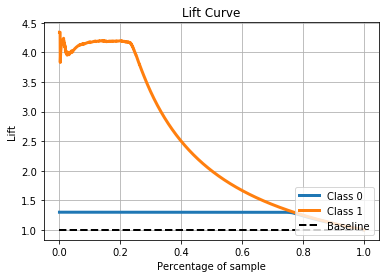

In [15]:
plot_lift_curve(y_test, y_score)
plt.show()

# CATEGORICA    (solo tempo)

utilizzo solo date e time per questa classificazione , condìsiderandoli gli unici due attributi categorici

di Time mantengo solo Hour ovvero l'ora per evitare overfitting 

tenedno conto che appare dalle analisi precendemtne fatte, per evitare ridondanza estraggo dalla data il giorno della settimana e controllo se è festivo, l' attributo <b>Holidays</b> assume cosi iil valore di 1 se il giorno è festivo




In [297]:
df['Hour']= df['Time'].apply(lambda x:str(x)[7:9]+str(x)[10])
#df['Date']= df['Date'].apply(lambda x:str(x)[8:10])

test['Hour']= test['Time'].apply(lambda x: str(x)[7:9]+str(x)[10])
#test['Date']= test['Date'].apply(lambda x:str(x)[8:10])

In [298]:
df['Holidays'] = df['Date'].apply(lambda x: 0 if x.weekday()<5 else 1 )
test['Holidays'] = test['Date'].apply(lambda x: 0 if x.weekday()<5 else 1 )

In [299]:
df['Holidays']=df['Holidays'].astype(str)
test['Holidays']=test['Holidays'].astype(str)
df['Hour']=df['Hour'].astype(str)
test['Hour']=test['Hour'].astype(str)

In [300]:
print(df[['Hour','Holidays']],df.dtypes)

      Hour Holidays
0      040        0
1      214        1
2      231        0
3      173        0
4      111        0
...    ...      ...
14386  003        0
14387  091        0
14388  045        0
14389  175        0
14390  230        0

[14391 rows x 2 columns] Unnamed: 0                 int64
Temperature              float64
Humidity                 float64
Light                    float64
CO2                      float64
HumidityRatio            float64
Occupancy                  int64
Time             timedelta64[ns]
Date              datetime64[ns]
Hour                      object
Holidays                  object
dtype: object


In [301]:
rdf=df[['Hour','Holidays']].copy()
rtest=test[['Hour','Holidays']].copy()

r=rdf.append(rtest)

In [302]:
X_train_cat=rdf.values
X_test_cat=rtest.values
y_train=df['Occupancy'].values
y_test=test['Occupancy'].values

attributes = ['Temperature','CO2','Light','Humidity'] 



    
X_train_cat =df[attributes].values
y_train=df['Occupancy'].values
X_test_cat=test[attributes].values
y_test=test['Occupancy'].values

In [303]:
clf = CategoricalNB()
clf.fit(X_train_cat, y_train)

CategoricalNB(alpha=1.0, class_prior=None, fit_prior=True)

In [304]:
y_pred = clf.predict(X_test_cat)
y_pred1 =y_pred
y_score=clf.predict_proba(X_test_cat)

In [305]:

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

#A quanto pare data e tmepo da soli sono sufficienti per avere già una buona classificazione

Accuracy 0.9567120622568094
F1-score [0.97176097 0.90732385]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      4747
           1       0.90      0.92      0.91      1421

    accuracy                           0.96      6168
   macro avg       0.94      0.94      0.94      6168
weighted avg       0.96      0.96      0.96      6168



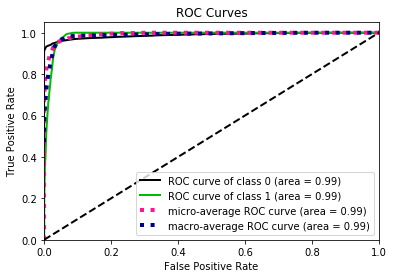

In [306]:
plot_roc(y_test, y_score)
plt.show()

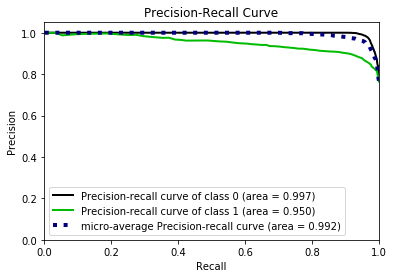

In [307]:
plot_precision_recall(y_test, y_score)
plt.show()

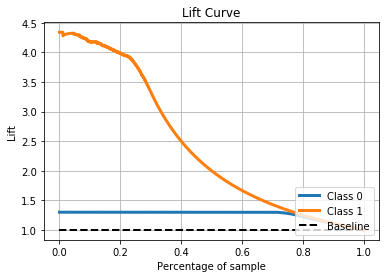

In [308]:

plot_lift_curve(y_test, y_score)
plt.show()

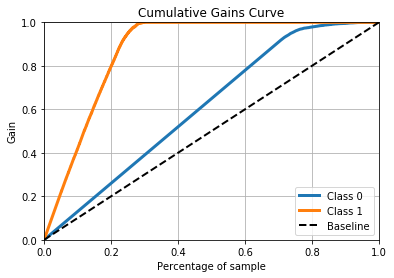

In [309]:
plot_cumulative_gain(y_test, y_score)
plt.show()

## comparison

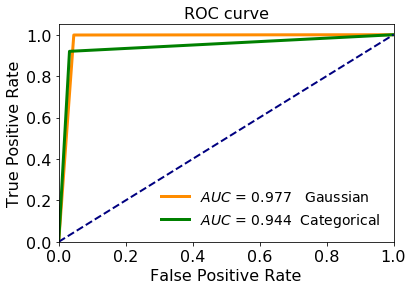

In [311]:
fpr0, tpr0, _ = roc_curve(y_test, y_pred0)
roc_auc0 = auc(fpr0, tpr0)

fpr1, tpr1, _ = roc_curve(y_test, y_pred1)
roc_auc1 = auc(fpr1, tpr1)


plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC$ = %.3f   Gaussian' % (roc_auc0))
plt.plot(fpr1, tpr1, color='green', lw=3, label='$AUC$ = %.3f  Categorical' % (roc_auc1))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()



In [113]:
df

,Unnamed: 0,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Time,Date,Hour,Holidays
0,794,20.70,24.8400,0.00,587.50,0.003746,0,04:01:00,2015-02-12,04,0
1,4742,19.79,35.2000,0.00,524.50,0.005028,0,21:49:00,2015-02-14,21,1
2,2120,20.89,25.2000,0.00,557.20,0.003846,0,23:19:00,2015-02-03,23,0
3,1426,22.20,24.3340,429.50,913.00,0.004025,1,17:36:00,2015-02-05,17,0
4,1397,22.08,28.3700,544.20,1198.60,0.004663,1,11:16:00,2015-02-03,11,0
...,...,...,...,...,...,...,...,...,...,...,...
14386,584,20.60,26.8900,0.00,508.00,0.004032,0,00:30:59,2015-02-12,00,0
14387,1278,21.20,25.3925,454.75,782.00,0.003950,1,09:16:59,2015-02-03,09,0
14388,6421,19.29,26.8900,0.00,465.50,0.003716,0,04:51:00,2015-02-09,04,0
14389,2885,21.70,20.8900,433.00,802.25,0.003348,1,17:55:00,2015-02-06,17,0


# BERNOULLI NB

Bernolli classifica utilizzando solo variabili binarie, tuttavia è possibile passargli anche float o categorci con piu di due valori possibili che verranno binarizzati

In [315]:
attributes = ['Temperature','CO2','Light','Humidity','Hour','Holidays'] 
X_train_B = df[attributes].copy()
X_test_B = test[attributes].copy()


In [316]:
X_train_B

,Temperature,CO2,Light,Humidity,Hour,Holidays
0,20.70,587.50,0.00,24.8400,040,0
1,19.79,524.50,0.00,35.2000,214,1
2,20.89,557.20,0.00,25.2000,231,0
3,22.20,913.00,429.50,24.3340,173,0
4,22.08,1198.60,544.20,28.3700,111,0
...,...,...,...,...,...,...
14386,20.60,508.00,0.00,26.8900,003,0
14387,21.20,782.00,454.75,25.3925,091,0
14388,19.29,465.50,0.00,26.8900,045,0
14389,21.70,802.25,433.00,20.8900,175,0


In [317]:
f=lambda x: str(x)[0]
for col in attributes[:4]:
    X_train_B[col]= [f(x) for x in X_train_B[col]]
    X_test_B[col] = [f(x) for x in X_test_B[col] ]

In [318]:
X_train_B=X_train_B.values
X_test_B=X_test_B.values

In [319]:
X_train_B

array([['2', '5', '0', '2', '040', '0'],
       ['1', '5', '0', '3', '214', '1'],
       ['2', '5', '0', '2', '231', '0'],
       ...,
       ['1', '4', '0', '2', '045', '0'],
       ['2', '8', '4', '2', '175', '0'],
       ['2', '5', '0', '3', '230', '0']], dtype=object)

In [320]:
attributes = ['Temperature','CO2','Light','Humidity','Hour','Holidays'] 
X_train_B = df[attribut]


    
X_train_B =df[attributes].values
y_train=df['Occupancy'].values
X_test_B=test[attributes].values
y_test=test['Occupancy'].values

NameError: name 'attribut' is not defined

In [322]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB()
clf.fit(X_train_B, y_train)

y_pred = clf.predict(X_test_B)
y_pred2 =y_pred
y_score=clf.predict_proba(X_test_B)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))


Accuracy 0.9620622568093385
F1-score [0.97473002 0.92392718]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      4747
           1       0.86      1.00      0.92      1421

    accuracy                           0.96      6168
   macro avg       0.93      0.98      0.95      6168
weighted avg       0.97      0.96      0.96      6168



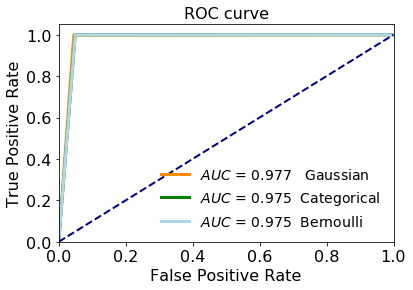

In [327]:
fpr0, tpr0, _ = roc_curve(y_test, y_pred0)
roc_auc0 = auc(fpr0, tpr0)

fpr1, tpr1, _ = roc_curve(y_test, y_pred1)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, y_pred2)
roc_auc2 = auc(fpr2, tpr2)


plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC$ = %.3f   Gaussian' % (roc_auc0))
plt.plot(fpr1, tpr1, color='green', lw=3, label='$AUC$ = %.3f  Categorical' % (roc_auc1))
plt.plot(fpr2, tpr2, color='lightblue', lw=3, label='$AUC$ = %.3f  Bernoulli' % (roc_auc2))


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()



# MULTINOMIAL NB

In [118]:
attributes = ['Temperature','CO2','Light','Humidity','Hour','Holidays'] 



    
X_train_cat =df[attributes].values
y_train=df['Occupancy'].values
X_test_cat=test[attributes].values
y_test=test['Occupancy'].values

In [119]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train_cat, y_train)

y_pred = clf.predict(X_test_cat)
y_pred1 =y_pred
y_score=clf.predict_proba(X_test_cat)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))


Accuracy 0.937905317769131
F1-score [0.9579629  0.88124031]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      4747
           1       0.79      1.00      0.88      1421

    accuracy                           0.94      6168
   macro avg       0.89      0.96      0.92      6168
weighted avg       0.95      0.94      0.94      6168



In [120]:
X_train_cat.shape

(14391, 6)